In [1]:
import sys
sys.path.append('..')

In [2]:
from importlib import reload
from os.path import exists

import networkx as nx
import numpy as np
import pandas as pd
import lib.obo
import lib.classification.elastic
import lib.classification.validation
import lib.utils
import data
import pymonad

reload(lib.classification.validation)
reload(lib.classification.elastic)
reload(lib.obo)
reload(lib.utils)
reload(data)

from lib.classification.elastic import annotate_index, collapse_matches, build_synonyms_graph
from lib.utils import map_series, expand_dataframe, expand, flatten
from lib.classification.validation import correct_ratio, incorrect_ratio, perfect_match
from geo_annotation.import_ontology_es import import_ontology
from elasticsearch import Elasticsearch
from lib.obo import read_ontology, Ontology
pd.set_option('display.width', 512)

In [3]:
import seaborn
%matplotlib inline

In [4]:
es = Elasticsearch()
ontology = read_ontology('../data/geo-annotation/doid-patched.obo',
                         exclude_duplicates=True)

Read obo graph
Name: 
Type: DiGraph
Number of nodes: 6595
Number of edges: 6594
Average in degree:   0.9998
Average out degree:   0.9998


In [5]:
# Убираем синонимы состоящие только из коротких слов  (len <= 2 )
# (вообще ошибка происходит изза стоп-слов в Elasticsearch, но так проще)

def cell():
    import re
    def tokenize(s):
        return re.split(r'[^\w\d]+', s)
    
    def all_short(synonym):
        return all(len(t) <= 2 for t in tokenize(synonym))
    
    for item_id, item in ontology.meta.items():
        item.synonyms = [s for s in item.synonyms if not all_short(s)]

cell()

In [6]:
import_ontology(ontology, 'disease_ontology')
syn_ontology = Ontology(build_synonyms_graph(ontology, es, 'disease_ontology'), list(ontology.items()))

In [ ]:
import pymongo
db = pymongo.MongoClient().scraper_meta
series_ids = [int(d['accession'][3:]) for d in db.series.find({'organism': 'Homo sapiens'}, {'_id': 0, 'accession': 1})]

In [ ]:
series_ids[:10]

In [7]:
annotation_result_file = '../data/geo-annotation/series.disease.res.homo.1.pickle'
if not exists(annotation_result_file):
    res = annotate_index(client=es,
                         ontology=ontology,
                         index='series',
                         ids=series_ids
                        )

    res.to_pickle(annotation_result_file)

else:
    res = pd.read_pickle(annotation_result_file)

In [8]:
len(res)

12495

In [9]:
def doid_id(item_id):
    return "DOID:{:07}".format(item_id)


def ontology_name(item_id):
    if item_id not in ontology.meta:
        return item_id
    return ontology.meta[item_id].name


def to_name(series_id):
    return "GSE{}".format(series_id)

def name(item_id):
    return '{} ({})'.format(ontology_name(item_id), item_id)

def names(df):
    return df.applymap(lambda xs: [name(x) for x in xs])

def sub_ontology(nodes, ontology):
    subset = set(flatten([nx.shortest_path(ontology.graph, 'DOID:4', cls) for cls in nodes]))
    for n in nodes:
        subset.add(n)
    return nx.subgraph(ontology.graph, subset)

def matches_graph(matches, vd_classes=None, figsize=None, prog='neato'):
    matches = [m for m in matches if m in ontology.graph.nodes()]
    vd_classes = vd_classes or []
    import matplotlib.pyplot as plt
    figsize = figsize or (14, 10)
    plt.figure(figsize=figsize) 
    import networkx as nx
    
    G = sub_ontology(matches + vd_classes, ontology)
    pos=nx.pygraphviz_layout(G, prog=prog) 
    
    labels = dict((k, v) for (k, v) in names_dict.items() if k in G.nodes())
    nodes_other = [x for x in G.nodes() if x not in matches]
    
    nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='r',
             alpha=0.5,
            nodelist=matches)
    
    nx.draw_networkx(G, labels=labels, 
        pos=pos, 
        node_size=400,
        node_color='w',
         alpha=0.8,
        nodelist=nodes_other)
    
    if vd_classes:
        nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='g',
            alpha=0.5,
#             font_color='g',                     
            nodelist=vd_classes)
        
    plt.show()

    
names_dict = dict((record.id, record.name) for record in ontology.meta.values())

In [10]:
cell_type_cancer = 'DOID:0050687'
organ_system_cancer = 'DOID:0050686'
cell_type_benign_neoplasm = 'DOID:0060084'
organ_system_benign_neoplasm = 'DOID:0060085'

@pymonad.curry
def exclude_similar_branches(ontology, classes):
    has_osc = any(ontology.has_path(organ_system_cancer, c) for c in classes)
    if has_osc:
        return [c for c in classes if not ontology.has_path(cell_type_cancer, c) 
#                                       and not ontology.has_path(cell_type_benign_neoplasm, c)
#                                       and not ontology.has_path(organ_system_benign_neoplasm, c) 
               ]
    else:
        return classes

In [11]:
root_disease = 'DOID:4'

@pymonad.curry
def exclude_wide_terms(ontology, classes):
    threshold = 4
    
    return [c for c in classes 
            if len(nx.shortest_path(ontology.graph, root_disease, c)) > threshold]

In [12]:
results = pd.DataFrame(dict(
        odinary=res.classes,
        collapsed=res.classes.map(exclude_wide_terms(ontology) *
                                  collapse_matches(ontology.graph)),
        collapsed_ex=res.classes.map(exclude_wide_terms(ontology) * 
                                     exclude_similar_branches(ontology) *
                                     collapse_matches(ontology.graph)),
#         collapsed_syn=res.classes.map(collapse_matches(syn_ontology.graph) *
#                                      exclude_wide_terms(ontology) * 
#                                      exclude_similar_branches(ontology) *
#                                      collapse_matches(ontology.graph)),
#         larisa=larisa_vd.classes,
    )
).applymap(lambda x: [] if isinstance(x, float) else x)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116ebaa20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117020be0>]], dtype=object)

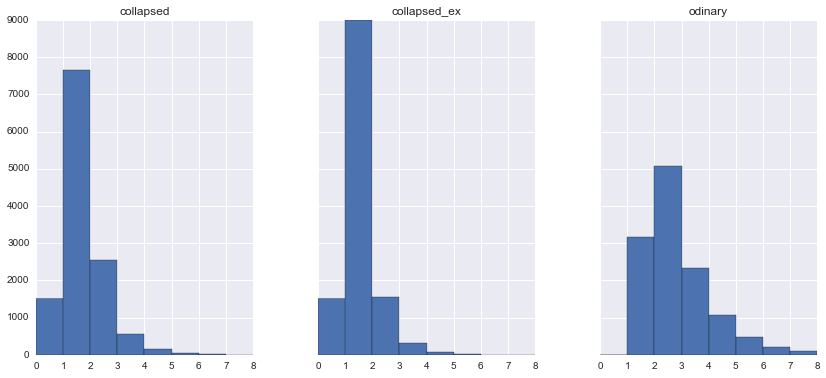

In [13]:
(
    results
    .applymap(len).hist(bins=range(0, 9), 
                        sharey=True, 
                        layout=(1, 3),
                        figsize=(14, 6))
 )

In [57]:
root_node = 'DOID:4'
root_node = 'DOID:162'
def descendants_level(graph, node, level):
    if level == 0:
        return [node]
    else:
        successors = graph.successors(node)
        res = []
        for succ in successors:
            res += descendants_level(graph, succ, level - 1)
        return res    
higer_nodes = [n for n in descendants_level(ontology.graph, root_node, 2)]
len(higer_nodes)

24

In [58]:
def cell():
    from collections import defaultdict
    aggreg = defaultdict(int)
    classes = results.collapsed_ex
    classes = (
        classes[classes.map(lambda x: len(x) == 1)].map(lambda x: x[0]).tolist()
    )
    
    for c in classes:
        for n in higer_nodes:
            if n == c or ontology.has_path(n, c):
                aggreg[n] += 1
                
    return pd.DataFrame.from_records(list(aggreg.items()), columns=['doid', 'count'])
stats = cell().sort(columns=['count'], ascending=False).assign(name=lambda x: x['doid'].map(name))
stats
    

,doid,count,name
10,DOID:5093,1432,thoracic cancer (DOID:5093)
9,DOID:0060083,1245,immune system cancer (DOID:0060083)
5,DOID:3119,1093,gastrointestinal system cancer (DOID:3119)
16,DOID:193,942,reproductive organ cancer (DOID:193)
1,DOID:0050615,456,respiratory system cancer (DOID:0050615)
2,DOID:3093,281,nervous system cancer (DOID:3093)
15,DOID:0060100,270,musculoskeletal system cancer (DOID:0060100)
12,DOID:1909,257,melanoma (DOID:1909)
4,DOID:3070,235,malignant glioma (DOID:3070)
3,DOID:305,234,carcinoma (DOID:305)


In [59]:
stats['count'].sum()

7027